# Models VII: 3+ level categorical predictors & One-way ANOVA

In notebook `05_models` we saw how we can *encode* a *categorical predictor with 2-levels* (`Student = (Yes or No)`) in a GLM using **treatment (dummy) codes**. 

Let's extend this idea to explore how to model categorical variables with **more thant 2 levels**

We're going to look at a new dataset that comes from the following paper:

[Meyer, G., von Meduna, M., Brosowski, T., & Hayer, T. (2012). Is poker a game of skill or chance? A quasi-experimental study. Journal of Gambling Studies](https://link.springer.com/article/10.1007/s10899-012-9327-8)

The experiments used a 2 (skill) x 3 (hand) x 2 (limit) design

This is reflected in the provided tidy-dataset which has 4 columns:

| Variable   | Description                     |
|------------|---------------------------------|
| skill     | a player's skill (expert/average)|
| hand     | the quality of the hand experimenters manipulate (bad/neutral/good)|
| limit     | the style of game (fixed/no-limit)|
| balance     | a player's final balance in Euros|

### Slides for reference

[Modeling Data VI (slides)](https://stat-intuitions.com/lectures/wk7/2.html)  

## Data

Let's load the data and verify the details above:

In [1]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
df = pl.read_csv('./data/poker-tidy.csv')
df.head()

skill,hand,limit,balance
str,str,str,f64
"""expert""","""bad""","""fixed""",4.0
"""expert""","""bad""","""fixed""",5.55
"""expert""","""bad""","""fixed""",9.45
"""expert""","""bad""","""fixed""",7.19
"""expert""","""bad""","""fixed""",5.71


This reflects the 300 participants in the experiment and 4 columns of our dataframe:

In [2]:
df.shape

(300, 4)

Challenge: Using polars, figure out how many observations there are per *cell* of the 2x3x2 design

In [ ]:
# Your code here

In [3]:
# Solution
df.group_by(['skill','hand', 'limit']).len()

skill,hand,limit,len
str,str,str,u32
"""expert""","""neutral""","""fixed""",25
"""average""","""neutral""","""no-limit""",25
"""average""","""good""","""fixed""",25
"""expert""","""bad""","""fixed""",25
"""expert""","""good""","""no-limit""",25
…,…,…,…
"""average""","""good""","""no-limit""",25
"""average""","""bad""","""fixed""",25
"""average""","""bad""","""no-limit""",25


## Categorical Predictor with 3 levels

The first question we're interested in testing is: **does having a better `hand` earn more money, i.e a higher `balance`?**

### Challenge: Visualization

Create a figure that plots data from each level of `hand` on the x-axis and `balance` on the y-axis

Add a bar or point that also reflect the *mean* balance at each level

In [ ]:
# Your code here

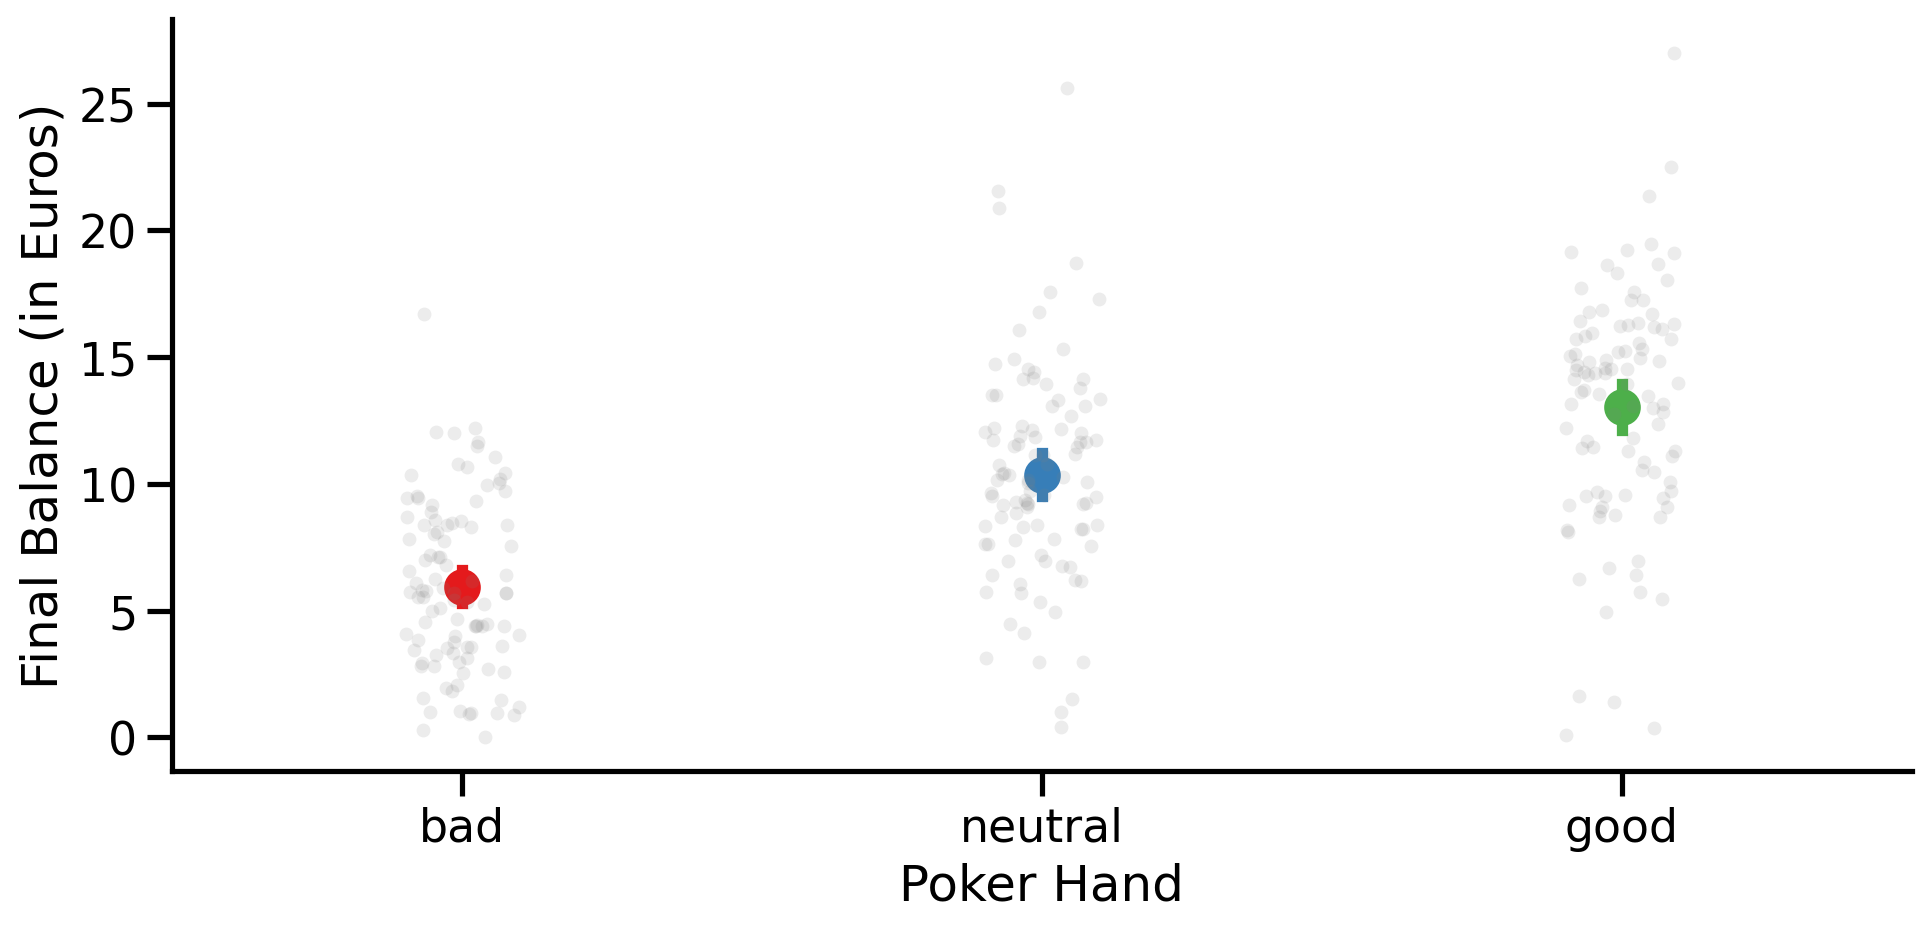

In [4]:
# Solution
order = ['bad', 'neutral', 'good']
with sns.plotting_context('talk'):
    grid = sns.FacetGrid(data=df, height=5, aspect=2)
    grid = grid.map(sns.stripplot, 'hand', 'balance', order=order, alpha=0.15, color='gray')
    grid.map_dataframe(sns.pointplot, 'hand', 'balance', hue='hand', order=order, hue_order=order, palette='Set1')
    grid.set_axis_labels('Poker Hand', 'Final Balance (in Euros)');

### Challenge: Worth it?

Like previous notebooks start by defining a *compact* model and an *augmented* model and then comparing them to see whether adding `hand` to a model reduces enough error to be worth it:

In [ ]:
# Your code here

In [5]:
# Solution
# Compact
model_c = ols('balance ~ 1', data=df.to_pandas())
results_c = model_c.fit()

# Augmented
model_a = ols('balance ~ C(hand)', data=df.to_pandas())
results_a = model_a.fit()

# Worth it?
anova_lm(results_c, results_a)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,299.0,7579.984625,0.0,NaN,NaN,NaN
1,297.0,5020.583223,2.0,2559.401402,75.702581,2.699281e-27


Use `anova_lm` with just your augmented model and the argument `type=3` to generate a One-way ANOVA table. How does this compare to model comparison you just did?

In [6]:
# Solution
anova_lm(results_a, type=3)

,df,sum_sq,mean_sq,F,PR(>F)
C(hand),2.0,2559.401402,1279.700701,75.702581,2.699281e-27
Residual,297.0,5020.583223,16.904321,NaN,NaN


### Interpreting Parameters

Let's try to understand how the GLM represented the levels of `hand`

Remember that the default for `C()` is to represent our categorical variable using **treatment/dummy codes** - with the reference level being the *alphabetically* first level in the data.

Using our helper plottign function we can visualize the **design matrix** for our model and see that it created **2 additional columns** to represent `hand`. In this case:
- Intercept = mean of `hand = 'bad'`
- $\beta_1$ = difference between `hand = 'good'` and `hand = 'bad'`
- $\beta_2$ = difference between `hand = 'neutral'` and `hand = 'bad'`

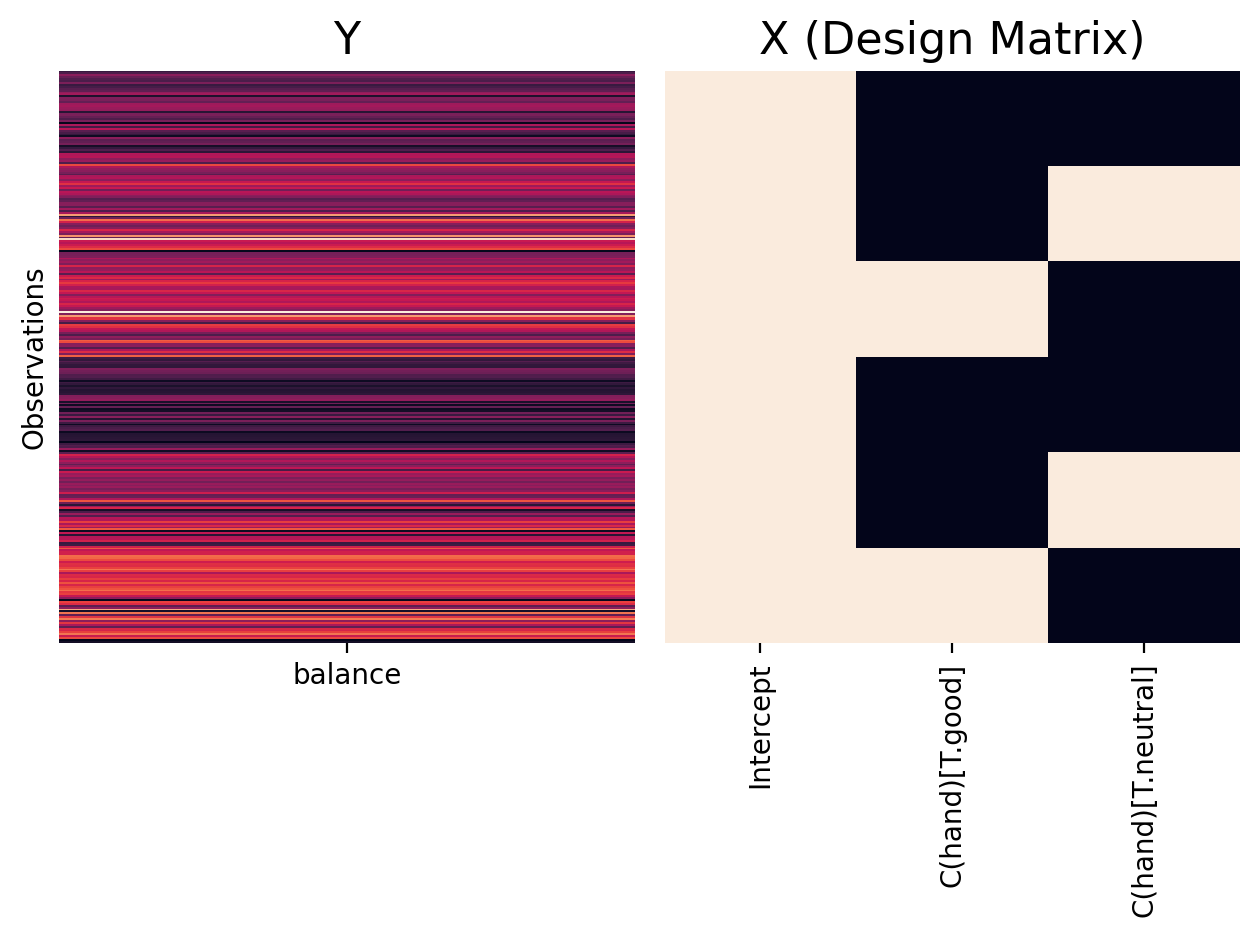

In [7]:
from helpers import plot_design_matrix

# In case you named your model something different above we redefine it here
model_a = ols('balance ~ C(hand)', data=df.to_pandas())

plot_design_matrix(model_a)

### Challenge

Use polars to calculate the mean for each level of `hand`. Then using the explanation of dummy-coding above, use the means to recreate what each parameter estimate represents.

Use `print` in Python or a markdown cell to write out your explanation

In [27]:
# Here are the parameters
# Can you get these values by using the means of each level of hand?
results_a.params

Intercept             5.9415
C(hand)[T.good]       7.0849
C(hand)[T.neutral]    4.4051
dtype: float64

In [ ]:
# Your code here

In [44]:
# Solution
hand_means = df.group_by('hand', maintain_order=True).agg(col('balance').mean())
bad = hand_means[0,1]
neutral = hand_means[1,1]
good = hand_means[2,1]

print(f'Intercept = Bad hand: {bad:.3f}')   
print(f"B1 = Good - Bad: {good - bad:.3f}")
print(f"B2 = Neutral - Bad: {neutral - bad:.3f}")

Intercept = Bad hand: 5.941
B1 = Good - Bad: 7.085
B2 = Neutral - Bad: 4.405


## Additional Coding Systems for Categorical Variables

What if we want to represent the levels of our categorical variable in different way? We already saw how to change the **reference** level when using treatment/dummy codes - but we can also use an entirely different approach.

In this section we'll cover the 2 additional common ways to *encode* categorical variables:
1. Deviation (Sum) Coding
2. Orthogonal Polynomial Coding

The reason to understand these additional encoding schemes is that they provide **valid inferences** when we extend our model to include additional categorical or continuous predictors.

Below we provide a brief overview of each coding scheme and how to use it but you should check-out the following resources as part of this lab as well:

- [Coding Systems for Categorical Variables](https://stats.oarc.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/#DEVIATION%20EFFECT%20CODING) *conceptual overview, but examples are in R*
- [Contrasts in StatsModels](https://www.statsmodels.org/stable/contrasts.html) *Shorter Python version of the guide above*
- [How to use different coding schemes in formulas](https://patsy.readthedocs.io/en/latest/API-reference.html#categorical-coding-ref)


| Scheme Name      | Intercept Interpretation             | Other Parameters Interpretation                                | Formula Syntax        | Affected by Unbalanced Designs? | Typical Usage                                  | Additional Notes or Customizations                                   | Interpretation Warnings and Guidance                                      |
|-----------------|------------------------------------|---------------------------------------------------------------|----------------------|--------------------------------|--------------------------------|------------------------------------------------------------------------|---------------------------------------------------------------------------|
| Treatment (Dummy) | Baseline (reference) category    | Difference from the reference category                        | `C(var, Treatment)`  | Yes                            | Default; good for categorical predictors with a natural reference      | Reference level can be set via `C(var, Treatment(reference=...)`        | Be mindful of choosing a meaningful reference category                   |
| Deviation (Sum)  | Grand mean                       | Difference from grand mean                                    | `C(var, Sum)`        | No                             | ANOVA-style contrasts; balanced designs                               | Ensures sum of contrasts = 0                                            | In unbalanced designs, parameter estimates may not match simple group means      |
| Polynomial      | Linear trend                      | Higher-order polynomial trends                               | `C(var, Poly, k)`    | No                             | Modeling trends in ordered categories                                | Useful for variables with lots of levels                                 | `k` determines the highest-order polynomial (e.g. linear, quadratic, etc)                           | 


### Deviation (Sum/Contrast) Coding

This form of coding uses the intercept to estimate the **grand-mean** (mean of means) of all levels and uses additional parameters to calculate the difference between each level and the grand-mean. This coding scheme is very useful when we have categorical variables with 3+ levels and **uneven group sizes** and want to perform valid F-tests (ANOVAs). 

*In the case of 2-levels $\hat{\beta_1}$ = 2x mean difference between levels*   

We can use this coding scheme with `C(hand, Sum)`

We will have 2 columns in our **design matrix** but now they encode `good` and `neutral` using 1s and 0s and represent `bad` using -1s.

In [45]:
# Estimate model
model_sum = ols("balance ~ C(hand, Sum(omit='bad'))", data=df.to_pandas())
results_sum = model_sum.fit()

In [46]:
# Print first 10 rows of the design matrix
model_sum.exog[:10, :]

array([[ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.]])

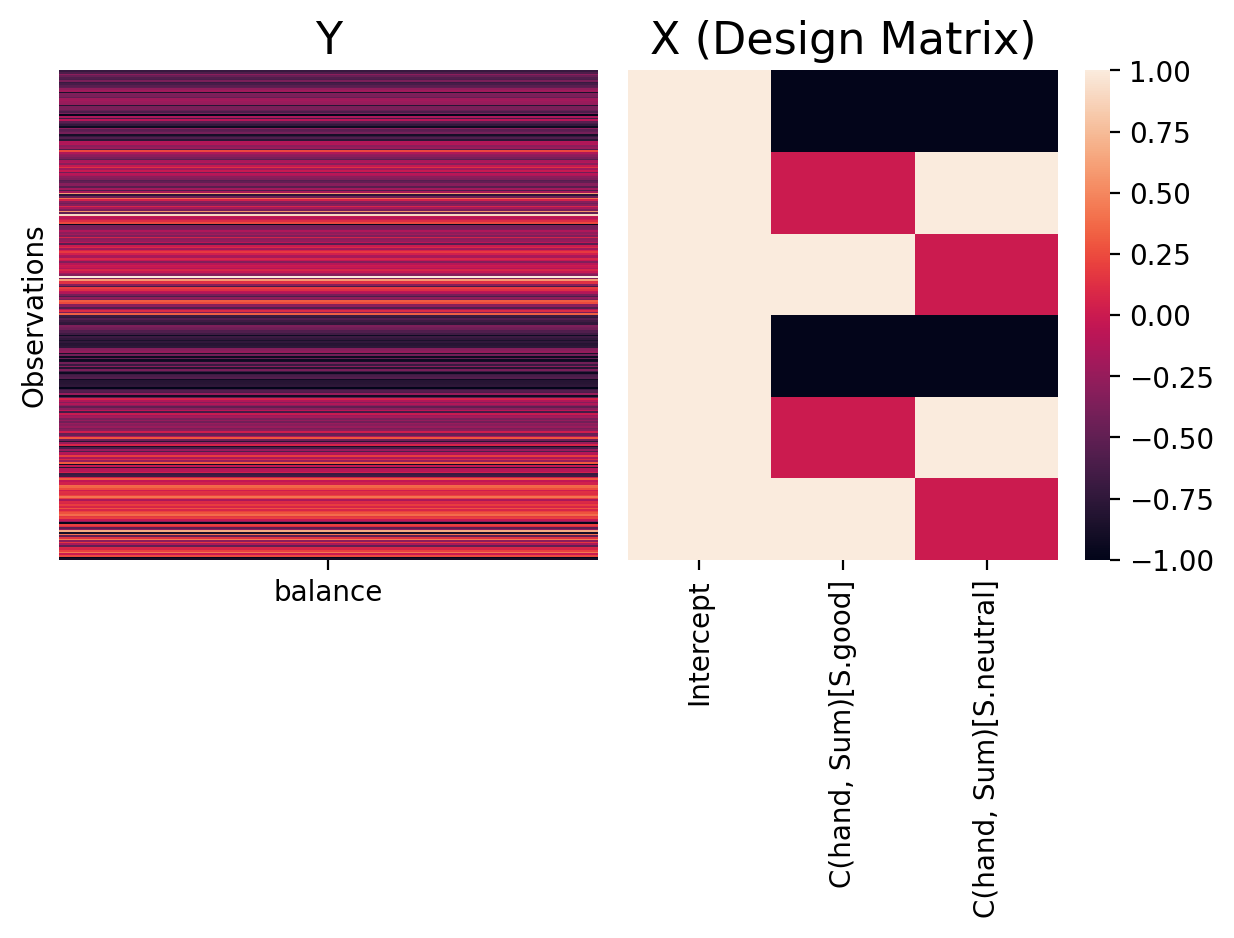

In [47]:
# Visualize the design matrix, adjust names, and add colorbar
plot_design_matrix(model_sum,
                    plot_names=['Intercept', 'C(hand, Sum)[S.good]', 'C(hand, Sum)[S.neutral]'], cbar=True)

Critically for valid ANOVA tests the sum over rows of this scheme adds up to 0:

In [48]:
model_sum.exog.sum(axis=0)

array([300.,   0.,   0.])

Compare this to our treatment/dummy coding which did not!

In [49]:
model_a.exog.sum(axis=0)

array([300., 100., 100.])

### Interpreting Parameters

In this coding scheme parameters represent:

- Intercept = the grand-mean of `balance` over all levels of `hand`
- $\beta_1$ = difference between the mean of `hand = 'good'` and the grand-mean
- $\beta_2$ = difference between the mean of `hand = 'neutral'` and the grand-mean

In [50]:
print(results_sum.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.333
No. Observations:                 300   F-statistic:                     75.70
Covariance Type:            nonrobust   Prob (F-statistic):           2.70e-27
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               9.7715      0.237     41.165      0.000       9.304      10.239
C(hand, Sum(omit='bad'))[S.good]        3.2549      0.336      9.696      0.000       2.594       3.916
C(hand, Sum(omit='bad'))[S.neutral]     0.5751      0.336      1.713      0.088      -0.086       1.236

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correc

### Challenge

Using the mean for each level of `hand` you calculated earlier and any other values you need to calculate, use the means to recreate what each parameter estimate represents

Use `print` in Python or a markdown cell to write out your explanation

In [ ]:
# Your code here

In [53]:
# Solution
grand_mean = np.mean([bad, good, neutral])

print(f"Intercept = Grand-mean = {grand_mean:.3f}")
print(f"B1 = Good - Grand-mean = {good - grand_mean:.3f}")
print(f"B2 = Neutral - Grand-mean = {neutral - grand_mean:.3f}")

Intercept = Grand-mean = 9.772
B1 = Good - Grand-mean = 3.255
B2 = Neutral - Grand-mean = 0.575


### Orthogonal Polynomial Coding

This form of coding uses the intercept to estimate the **grand-mean** (mean of means) of all levels and uses additional parameters to calculate polynomial trends across levels of the categorical variable, i.e. *linear*, *quadratic*, *cubic*, etc.

We can use this coding scheme with `C(Student, Poly)`

In [54]:
# Estimate model
model_poly = ols("balance ~ C(hand, Poly)", data=df.to_pandas())
results_poly = model_poly.fit()

In [55]:
# Print first 10 rows of the design matrix
model_poly.exog[:10, :]

array([[ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829],
       [ 1.        , -0.70710678,  0.40824829]])

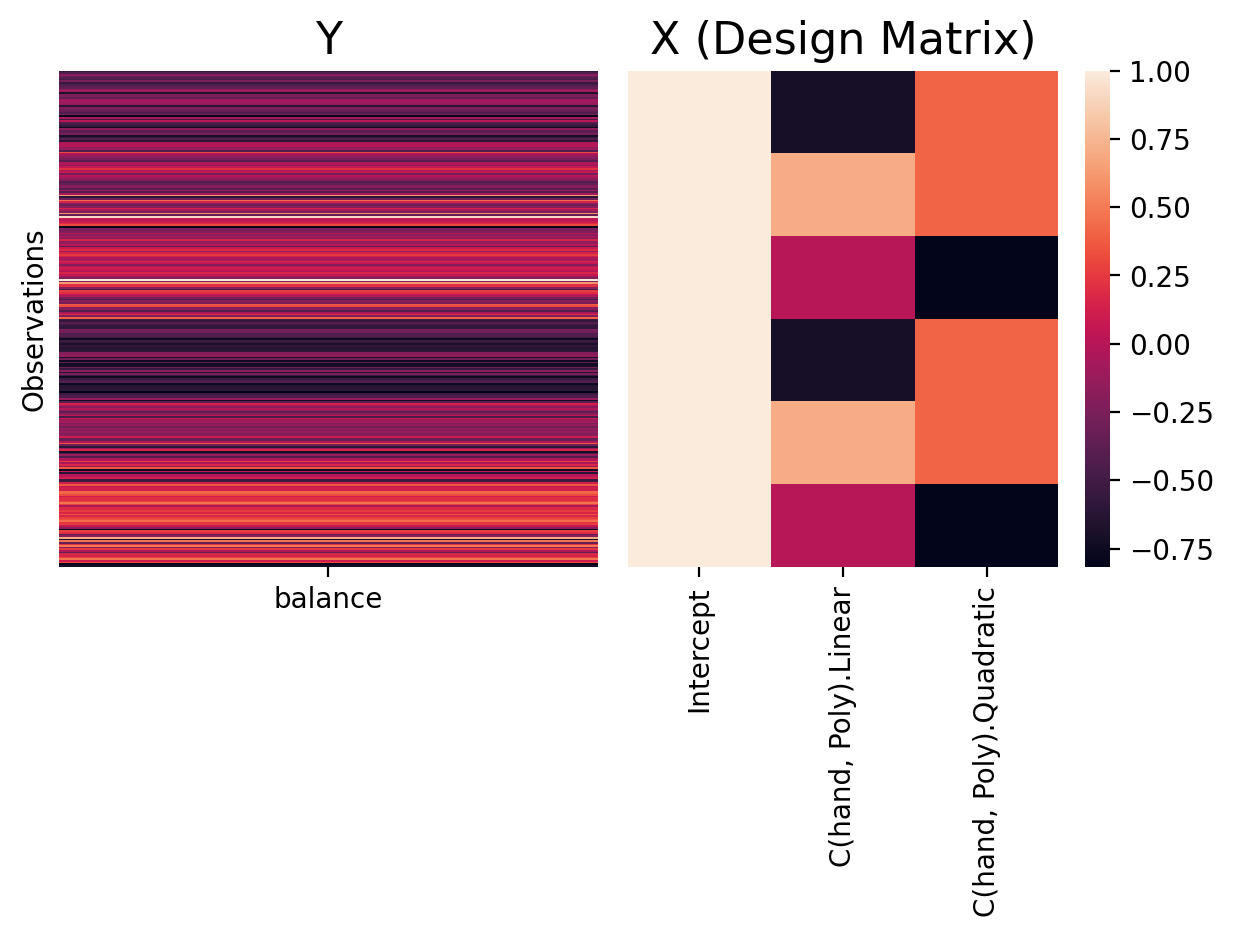

In [56]:
# Visualize the design matrix
plot_design_matrix(model_poly, cbar=True)

Like sum/deviation coding, polynomial contrasts are for valid ANOVA tests as the sum over rows of this scheme adds up to 0:

In [57]:
model_poly.exog.sum(axis=0)

array([ 3.00000000e+02, -5.06586146e-15, -1.55653268e-13])

### Interpreting Parameters

In this coding scheme parameters represent:

- Intercept = the grand-mean of `balance` over all levels of `hand`
- $\beta_1$ = linear trend over levels of `hand`
- $\beta_2$ = quadratic trend over levels of `hand`

To see this more clearly let's visualize how `Poly` is *encoding* levels of `hand`

In [58]:
# Import the Poly function which we don't normally use directly
from patsy.contrasts import Poly

# Generate a matrix using our predictor variables
poly_codes = Poly().code_without_intercept(model_poly.exog_names).matrix

poly_codes = pl.DataFrame(poly_codes, 
                          schema=['linear', 'quadratic']).with_columns(
                              hand = np.array(['bad', 'good','neutral']))


The matrix above is like a "mini" **design matrix**  mapping the levels of `hand` to the polynomial value

Visually if we think about each level of `hand` on the x-axis below we can see how the polynomial value changes:

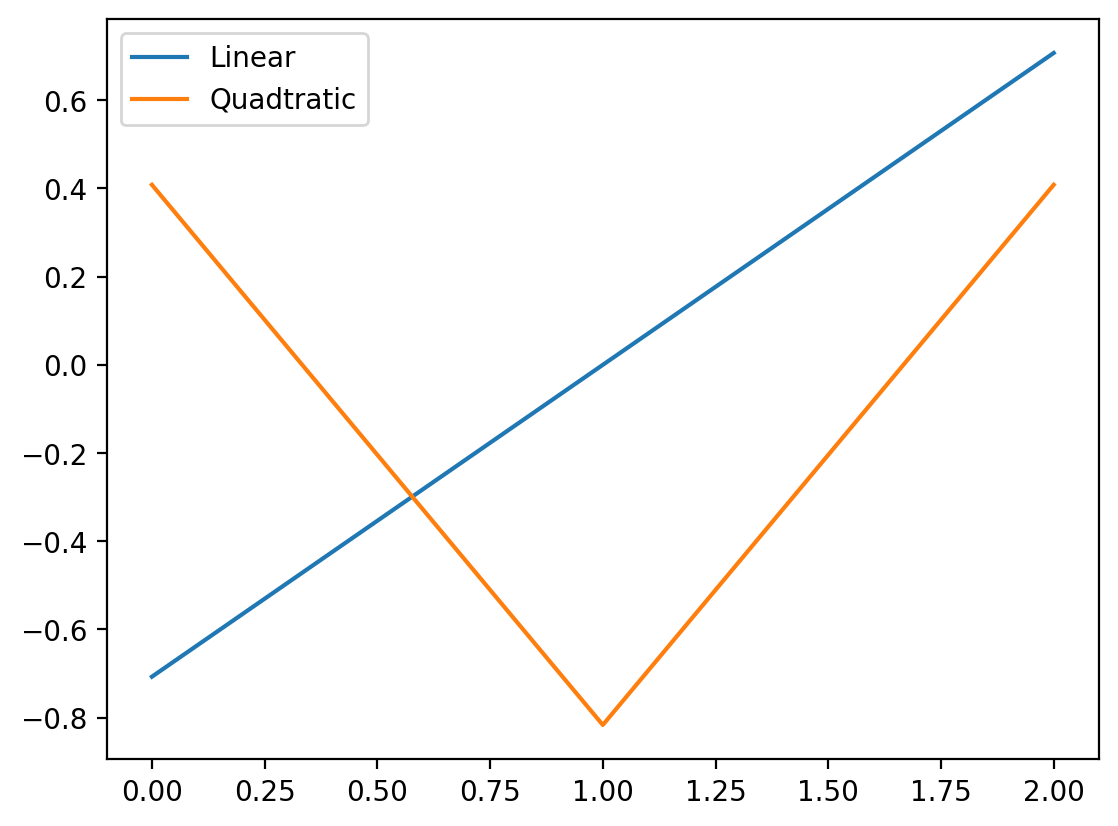

In [59]:
plt.plot(poly_codes[:, 0], label='Linear')
plt.plot(poly_codes[:, 1], label='Quadtratic')
plt.legend();

In [60]:
print(results_poly.summary(slim=True))

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.333
No. Observations:                 300   F-statistic:                     75.70
Covariance Type:            nonrobust   Prob (F-statistic):           2.70e-27
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   9.7715      0.237     41.165      0.000       9.304      10.239
C(hand, Poly).Linear        3.1149      0.411      7.576      0.000       2.306       3.924
C(hand, Poly).Quadratic    -3.9864      0.411     -9.696      0.000      -4.796      -3.177

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


### Challenge

Using the mean for each level of `hand` you calculated earlier and the `poly_codes` matrix below try to recreate the value for the linear and quadratic estimates above.

*Hint: Think about using `np.dot`...*


In [ ]:
# Use the first 2 columns of this matrix
poly_codes

linear,quadratic,hand
f64,f64,str
-0.707107,0.408248,"""bad"""
-1.6940e-17,-0.816497,"""good"""
0.707107,0.408248,"""neutral"""


In [64]:
# Solution
linear_codes = poly_codes[:, 0].to_numpy()
linear_contrast = np.dot([bad, good, neutral], linear_codes)

quadratic_codes = poly_codes[:, 1].to_numpy()
quadratic_contrast = np.dot([bad, good, neutral], quadratic_codes)

print(f"Linear contrast: {linear_contrast:.3f}")
print(f"Quadratic contrast: {quadratic_contrast:.3f}")

Linear contrast: 3.115
Quadratic contrast: -3.986
